In [1]:
!pip install PyGithub
!pip install pandas
!pip install matplotlib

In [17]:
from github import Github
import pandas as pd
from datetime import datetime
import pandas as pd
import os

import matplotlib.pyplot as plt

token = os.getenv("GITHUB_TOKEN")
# Authenticate with GitHub
g = Github(token)

# Get the repository
repo = g.get_repo("microsoft/terraform-provider-power-platform")

# Compute the average number of review comments per PR by category for AI-assisted vs non-ai-assisted PRs.
prs = []
pulls = repo.get_pulls(state="all")  # query all PRs, not filtering on closed
for pr in pulls:
    if pr.user.login == "dependabot[bot]":
        continue

    is_ai_assisted = any(label.name.lower() == 'ai assisted' for label in pr.labels)
    category = 'ai-assisted' if is_ai_assisted else 'non-ai-assisted'
        # Initialize variable to hold the earliest comment date
    first_comment_at = None

    # Check issue comments
    for comment in pr.get_issue_comments():
        if first_comment_at is None or comment.created_at < first_comment_at:
            first_comment_at = comment.created_at

    # Check review comments
    for comment in pr.get_review_comments():
        if first_comment_at is None or comment.created_at < first_comment_at:
            first_comment_at = comment.created_at

    prs.append({
        'review_comments': pr.review_comments,
        'first_comment_at': first_comment_at,

        'closed_at': pr.closed_at,
        'created_at': pr.created_at,
        'category': category
    })



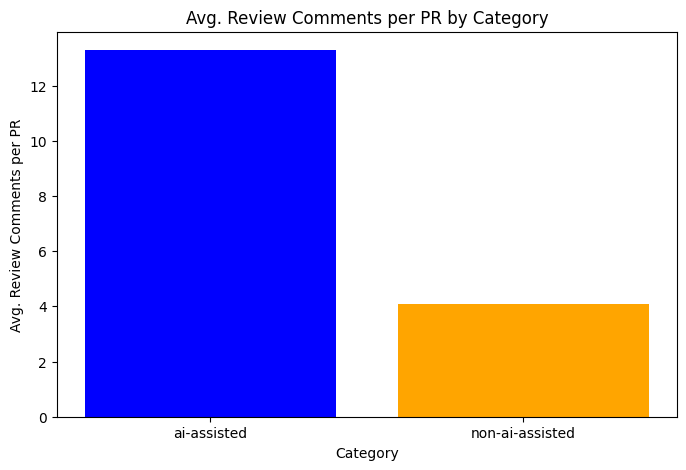

In [18]:
df_reviews = pd.DataFrame(prs)
avg_reviews = df_reviews.groupby('category')['review_comments'].mean().reset_index()

# Plot bar chart with one bar per category
plt.figure(figsize=(8, 5))
plt.bar(avg_reviews['category'], avg_reviews['review_comments'], color=['blue', 'orange'])
plt.xlabel('Category')
plt.ylabel('Avg. Review Comments per PR')
plt.title('Avg. Review Comments per PR by Category')
plt.show()

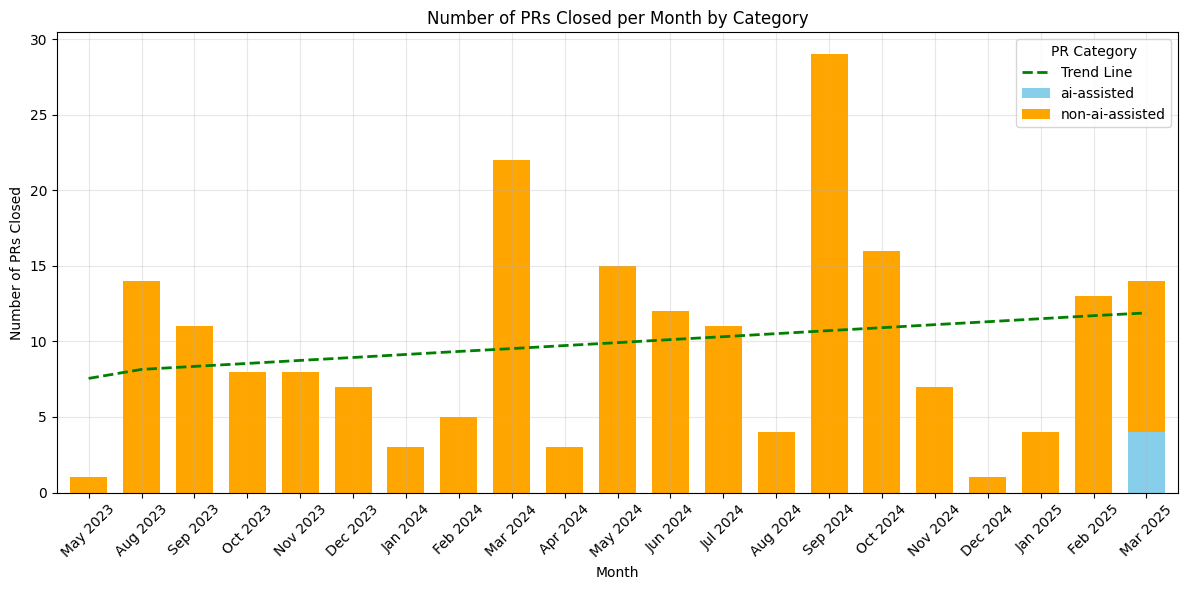

In [23]:
# Extract month from closed_at and count PRs per month, categorized by AI assistance
df['month'] = pd.to_datetime(df['closed_at']).dt.strftime('%Y-%m')
# Group by month and category, then count PRs
monthly_category_counts = df.groupby(['month', 'category']).size().unstack(fill_value=0)

# Convert index to datetime for proper sorting and plotting
monthly_category_counts.index = pd.to_datetime(monthly_category_counts.index + '-01')
monthly_category_counts = monthly_category_counts.sort_index()

# Calculate total counts for rolling average and trendline
monthly_counts = monthly_category_counts.sum(axis=1).reset_index()
monthly_counts.columns = ['month', 'pr_count']

# Calculate 3-month rolling average
rolling_avg = monthly_counts['pr_count'].rolling(window=3).mean()

# Create numeric X values for trendline calculation
x_numeric = np.array([(date - monthly_counts['month'].iloc[0]).days for date in monthly_counts['month']])
y = monthly_counts['pr_count'].values

# Calculate the trendline using polyfit
z = np.polyfit(x_numeric, y, 1)
p = np.poly1d(z)
trendline = p(x_numeric)

# Create the stacked bar chart with lines
plt.figure(figsize=(12, 6))

# Plot stacked bars
monthly_category_counts.plot(kind='bar', stacked=True, ax=plt.gca(), 
                            color=['skyblue', 'orange'], width=0.7)

# Plot rolling average and trendline on secondary axis
#plt.plot(range(len(monthly_counts)), rolling_avg, 'r-', linewidth=2, label='3-Month Rolling Average')
plt.plot(range(len(monthly_counts)), trendline, 'g--', linewidth=2, label='Trend Line')

# Format x-axis labels to Month Year format
ax = plt.gca()
labels = [date.strftime('%b %Y') for date in monthly_category_counts.index]
ax.set_xticklabels(labels)

plt.xlabel('Month')
plt.ylabel('Number of PRs Closed')
plt.title('Number of PRs Closed per Month by Category')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.legend(title='PR Category')
plt.tight_layout()
plt.show()
